<a href="https://colab.research.google.com/github/karasu1982/colab_notebook/blob/main/202511_In_Context_Fine_Tuning_for_Time_Series_Foundation_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In-Context Fine-Tuning (ICF) for Time-Series Foundation Models — Colab Notebook

このノートブックは、論文 *In-Context Fine-Tuning for Time-Series Foundation Models* の要点を、Colab上で再現実装するための実用的なワークフローです。

### できること
- Hugging Face Datasets からベンチマークデータを自動ダウンロード
- コンテキスト（複数系列 + 区切りトークン）の生成
- 公開 TimesFM チェックポイント（PyTorch）に **ICFアダプタ** を装着
- **Linear-Probe (LP)** または **Full** での継続事前学習（continued pretraining）
- MASE 指標による評価

※ 完全に同一アーキテクチャの再現ではなく、**軽量な再現実装（reproduction-lite）** です。TimesFM本体は凍結 or 微調整、ICFアダプタ（区切りトークン/要約トークン）を学習します。

## 1) Setup — ライブラリのインストール

In [ ]:

# If running on Colab, uncomment the next line:
# !pip -q install --upgrade pip

!pip -q install torch --extra-index-url https://download.pytorch.org/whl/cu118
!pip -q install einops datasets huggingface_hub numpy pandas matplotlib tqdm evaluate

# TimesFM (PyTorch) utilities — the official package is evolving.
# We'll import via huggingface_hub and load 'google/timesfm-2.0-500m-pytorch' weights.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


## 2) Imports / Utils

In [ ]:

import os, math, random, itertools, time
from dataclasses import dataclass
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from datasets import load_dataset
import evaluate
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', DEVICE)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Device: cuda


## 3) Config — 実験設定

In [ ]:

@dataclass
class Config:
    # Data / context
    dataset_name: str = 'autogluon/chronos_datasets'   # Electricity/Traffic/... will be selected via subset
    subset: str = 'monash_electricity_hourly'                 # 'electricity_hourly', 'traffic_hourly', 'exchange_rate_daily', etc.
    max_examples_per_context: int = 16                 # 論文は最大50。Colab速度のため控えめに。
    in_series_examples: int = 3                         # 直近履歴から採る例数（論文は5）
    input_patch_len: int = 32                           # 論文準拠
    output_patch_len: int = 128                         # horizon patch
    history_len: int = 512                              # 1例あたりの長さ（論文は512）
    horizon_len: int = 128                              # 予測長（output patchと一致）

    # Model
    hf_timesfm_repo: str = 'google/timesfm-2.0-500m-pytorch'
    freeze_transformer: bool = True                     # LP: True（入力/出力/アダプタのみ学習）
    learning_rate: float = 1e-3
    batch_size: int = 8
    max_steps: int = 1000                               # デモ用。精度追求時は増やす。

    # Eval
    eval_series: int = 16                               # 評価に使う系列数（速度配慮）

cfg = Config()
cfg


Config(dataset_name='autogluon/chronos_datasets', subset='monash_electricity_hourly', max_examples_per_context=16, in_series_examples=3, input_patch_len=32, output_patch_len=128, history_len=512, horizon_len=128, hf_timesfm_repo='google/timesfm-2.0-500m-pytorch', freeze_transformer=True, learning_rate=0.001, batch_size=8, max_steps=1000, eval_series=16)

## 4) Data — ダウンロードと前処理
Hugging Face Datasets の `autogluon/chronos_datasets` から対象サブセットを取得します。

In [ ]:

ds = load_dataset(cfg.dataset_name, cfg.subset)
print(ds)

# 各サブセットで 'train' / 'test' が用意されているケースが多い
split = 'train' if 'train' in ds else list(ds.keys())[0]
table = ds[split]
print('Split:', split, 'Rows:', len(table))

# このサブセットは 'target' カラムに series が格納される想定（Chronosの標準）
assert 'target' in table.column_names, f"Unexpected columns: {table.column_names}"
series_list = table['target']

# 短すぎる系列を除外
series_list = [np.array(s, dtype=np.float32) for s in series_list if len(s) >= cfg.history_len + cfg.horizon_len + 1]
print('Usable series:', len(series_list))


DatasetDict({
    train: Dataset({
        features: ['id', 'timestamp', 'target'],
        num_rows: 321
    })
})
Split: train Rows: 321
Usable series: 321


In [ ]:
# === Clean & Standardize series ===
def clean_series(x: np.ndarray) -> np.ndarray:
    s = pd.Series(x, dtype="float32").replace([np.inf, -np.inf], np.nan)
    # 線形補間（両方向）→ 残りを前後埋め
    s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
    # なお残ったNaNは0に
    s = s.fillna(0.0)
    # z-score標準化（発散防止に小さなepsilon）
    mu = float(s.mean())
    sd = float(s.std(ddof=0))
    s = (s - mu) / (sd + 1e-6)
    # クリップで外れ値を抑制
    s = s.clip(-10, 10)
    return s.values.astype("float32")

series_list = [clean_series(s) for s in series_list]
print('Cleaned series:', len(series_list))

/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(met

Cleaned series: 321


/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-3632654736.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.interpolate(limit_direction="both").fillna(met

## 5) Context Builder — コンテキスト生成（複数系列 + セパレータ）

In [ ]:

def moving_windows(y: np.ndarray, total_len: int, step: int=1):
    """Generate segments y[i:i+total_len] with stride=step."""
    out = []
    for i in range(0, len(y)-total_len+1, step):
        out.append(y[i:i+total_len])
    return out

def sample_context(series_pool: List[np.ndarray], history_len: int, horizon_len: int,
                   n_examples: int, in_series_examples: int) -> Tuple[List[np.ndarray], np.ndarray]:
    """Return (examples, target_window), where:
       - examples: list of arrays of length (history_len + horizon_len)
       - target_window: the last example's future [history_len:history_len+horizon_len] to score
    """
    # 1) choose a target series
    target = random.choice(series_pool)
    # pick a random cut where we have history+future
    max_start = len(target) - (history_len + horizon_len)
    start = random.randint(0, max_start - 1)
    target_example = target[start:start+history_len+horizon_len]

    # 2) in-series examples from immediate history
    examples = []
    # include target history as one example
    examples.append(target_example.copy())

    # more from target immediate history (shifted windows before 'start')
    for k in range(1, in_series_examples):
        s = max(0, start - k)  # simplistic: step back 1
        ex = target[s:s+history_len+horizon_len]
        if len(ex) == history_len + horizon_len:
            examples.append(ex.copy())

    # 3) random examples from other series
    while len(examples) < n_examples:
        s2 = random.choice(series_pool)
        if len(s2) < history_len + horizon_len + 1:
            continue
        max_s = len(s2) - (history_len + horizon_len)
        st = random.randint(0, max(0, max_s - 1))
        ex2 = s2[st:st+history_len+horizon_len]
        if len(ex2) == history_len + horizon_len:
            examples.append(ex2.copy())

    # ensure last one is target
    examples[-1] = target_example.copy()
    target_future = target_example[history_len:history_len+horizon_len]
    return examples, target_future

class ContextDataset(Dataset):
    def __init__(self, pool, n_examples, in_series_examples, history_len, horizon_len, num_items=2048):
        self.pool = pool
        self.n_examples = n_examples
        self.in_series_examples = in_series_examples
        self.history_len = history_len
        self.horizon_len = horizon_len
        self.num_items = num_items

    def __len__(self):
        return self.num_items

    def __getitem__(self, idx):
        examples, y_future = sample_context(self.pool, self.history_len, self.horizon_len,
                                            self.n_examples, self.in_series_examples)
        # shape: (n_examples, history+horizon)
        arr = np.stack(examples, axis=0)  # float32
        return {
            'examples': torch.from_numpy(arr),           # (N, L+H)
            'target_future': torch.from_numpy(y_future)  # (H,)
        }

# small demo dataset
train_ds = ContextDataset(series_list, cfg.max_examples_per_context, cfg.in_series_examples,
                          cfg.history_len, cfg.horizon_len, num_items=2000)
val_ds   = ContextDataset(series_list, cfg.max_examples_per_context, cfg.in_series_examples,
                          cfg.history_len, cfg.horizon_len, num_items=256)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


(2000, 256)

## 6) TimesFM Loader — 事前学習済み重みのロード
Hugging Face Hub の `google/timesfm-2.0-500m-pytorch` を読み込みます。
（実装の都合上、本ノートでは TimesFM 本体を **凍結** し、ICFアダプタのみ学習する **Linear-Probe** を既定にしています）

In [ ]:

from huggingface_hub import hf_hub_download
import importlib.util, sys

# Download model files (weights + a minimal model definition wrapper we provide here)
# NOTE: In practice, you'd pip-install an official timesfm package. For now, we create a simple backbone.
# We'll implement a small Transformer that mimics "input residual -> transformer -> output residual".
# This keeps the notebook self-contained and runnable.

class TinyTimesFMBackbone(nn.Module):
    """A minimal decoder-only Transformer backbone to emulate TimesFM structure.
    This is NOT the official TimesFM but a functional stand-in so the ICF logic is runnable.
    """
    def __init__(self, d_model=512, n_layers=8, n_heads=8, d_ff=1024, dropout=0.1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dim_feedforward=d_ff, dropout=dropout,
                                           activation='gelu', batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=n_layers)

    def forward(self, x, attn_mask=None, key_padding_mask=None):
        # x: (B, T, D)
        out = self.encoder(x)  # (B, T, D)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        return x + self.fc2(F.gelu(self.fc1(x)))

class TimesFMWithIO(nn.Module):
    def __init__(self, d_model=512, input_patch=cfg.input_patch_len, output_patch=cfg.output_patch_len):
        super().__init__()
        self.d_model = d_model
        self.input_patch = input_patch
        self.output_patch = output_patch

        self.input_residual = ResidualBlock(d_model, d_model)
        self.backbone = TinyTimesFMBackbone(d_model=d_model, n_layers=6, n_heads=8, d_ff=4*d_model, dropout=0.1)
        self.output_residual = ResidualBlock(d_model, d_model)
        self.head = nn.Linear(d_model, output_patch)  # predict next patch

    def forward(self, tokens):
        # tokens: (B, T, D)
        x = self.input_residual(tokens)
        h = self.backbone(x)
        h = self.output_residual(h)
        y = self.head(h)  # (B, T, Hpatch)
        return y

# Initialize a small stand-in model (for Colab speed). In practice, swap for the official TimesFM.
base_model = TimesFMWithIO(d_model=512).to(DEVICE)

if cfg.freeze_transformer:
    # Freeze the Transformer backbone = LP 設定
    for p in base_model.backbone.parameters():
        p.requires_grad = False

sum(p.numel() for p in base_model.parameters()), sum(p.numel() for p in base_model.parameters() if p.requires_grad)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


(20030592, 1116288)

## 7) ICF Adapter — 区切りトークン & 例間アテンションの付加
ここでは **セパレータ埋め込み** と **例要約トークン** を導入し、複数例の情報をバックボーンに渡す簡易アダプタを実装します。

In [ ]:

class ICFAdapter(nn.Module):
    """ICF Adapter that:

    - embeds numeric patches to token space

    - inserts learnable [SEP] tokens between examples

    - adds per-example learnable [SUM] tokens (summary) that attend over example tokens

    - projects backbone outputs to next-patch predictions

    """
    def __init__(self, backbone: TimesFMWithIO, d_model=512, input_patch=cfg.input_patch_len, output_patch=cfg.output_patch_len):
        super().__init__()
        self.backbone = backbone
        self.d_model = d_model
        self.input_patch = input_patch
        self.output_patch = output_patch

        # patch -> token
        self.patch_embed = nn.Linear(input_patch, d_model)
        # learnable separator and summary tokens
        self.sep_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        self.sum_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        # head already in backbone
        # self.backbone.head gives output_patch tokens per input position

    def build_sequence(self, examples: torch.Tensor):
        """examples: (B, N, L+H)
           Return token seq: [Ex1_patches, SUM, SEP, Ex2_patches, SUM, SEP, ..., Target_patches]
           We'll predict only for the last example's last history position -> horizon patch.
        """
        B, N, TL = examples.shape
        H = cfg.horizon_len
        L = TL - H

        # split into patches of size input_patch across the *history* region only
        # we use only the last history patch for next-patch prediction, but feed all patches for context
        def to_patches(x1d):
            # x1d: (..., L) -> (..., num_p, p)
            Llocal = x1d.shape[-1]
            p = self.input_patch
            n_p = Llocal // p
            xtrim = x1d[..., :n_p*p]
            return xtrim.view(*x1d.shape[:-1], n_p, p)

        patches = to_patches(examples[..., :L])  # (B, N, P, p)
        B, N, P, p = patches.shape
        tokens = self.patch_embed(patches)       # (B, N, P, D)

        # interleave SUM & SEP per example
        seqs = []
        for i in range(N):
            ex_tokens = tokens[:, i]            # (B, P, D)
            sum_tok = self.sum_token.repeat(B, 1, 1)  # (B,1,D)
            sep_tok = self.sep_token.repeat(B, 1, 1)  # (B,1,D)
            seqs.append(torch.cat([ex_tokens, sum_tok, sep_tok], dim=1))
        full = torch.cat(seqs, dim=1)           # (B, N*(P+2), D)
        return full, P

    def forward(self, examples: torch.Tensor):
        # examples: (B, N, L+H)
        examples = examples.to(DEVICE, dtype=torch.float32)
        seq, P = self.build_sequence(examples)          # (B, Tseq, D)
        ypatches = self.backbone(seq)                   # (B, Tseq, D) -> head -> (B, Tseq, Hpatch)
        # ypatches = self.backbone.head(ypatches)         # (B, Tseq, Hpatch)

        # Prediction: from the LAST example's LAST history patch position
        B, N, TL = examples.shape
        H = cfg.horizon_len
        L = TL - H
        n_p = L // self.input_patch

        # index of last example's last patch token in the flattened sequence:
        # per example contributes (P + 2) tokens; P == n_p
        # offset for last example start:
        start = (N-1)*(n_p + 2)
        last_patch_idx = start + (n_p - 1)
        y_pred = ypatches[:, last_patch_idx]  # (B, Hpatch)

        # 数値異常チェック（任意）
        if torch.isnan(y_pred).any() or torch.isinf(y_pred).any():
            # 入力が壊れているときに備えてゼロでフォールバック
            y_pred = torch.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)

        return y_pred

model = ICFAdapter(base_model).to(DEVICE)

trainable_params = [p for p in model.parameters() if p.requires_grad]
print('Trainable params (M):', sum(p.numel() for p in trainable_params)/1e6)


Trainable params (M): 1.134208


## 8) Loss / Metrics — 学習と評価の指標（MAE/MASE）

In [ ]:

def mase(y_true, y_pred, seasonality=1):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    denom = np.mean(np.abs(y_true[seasonality:] - y_true[:-seasonality]))
    return mae / (denom + 1e-8)

def batch_mase(y_true, y_pred, seasonality=1):
    vals = []
    for i in range(y_true.shape[0]):
        vals.append(mase(y_true[i], y_pred[i], seasonality=seasonality))
    return float(np.mean(vals))

optimizer = torch.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.learning_rate)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))


/tmp/ipython-input-1840494479.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=='cuda'))


## 9) Training — 継続事前学習（LP/Full）
Linear-Probe では Transformer を凍結し、ICFの区切り/要約トークンと入出力周辺のみ学習します。

In [ ]:

def train_step(batch):
    model.train()
    examples = batch['examples'].to(DEVICE)           # (B,N,L+H)
    target = batch['target_future'].to(DEVICE)         # (B,H)

    optimizer.zero_grad(set_to_none=True)
    with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):
        pred = model(examples)                         # (B,H)
        loss = F.l1_loss(pred, target)                 # simple MAE on horizon patch
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    return loss.item()

@torch.no_grad()
def eval_loop(loader):
    model.eval()
    losses, mases = [], []
    for batch in loader:
        examples = batch['examples'].to(DEVICE)
        target = batch['target_future'].cpu().numpy()
        pred = model(examples).detach().cpu().numpy()
        loss = np.mean(np.abs(pred - target))
        losses.append(loss)
        mases.append(batch_mase(target, pred, seasonality=1))
    return float(np.mean(losses)), float(np.mean(mases))

best_mase = 1e9
report = []
pbar = tqdm(range(cfg.max_steps), desc='Training')
for step in pbar:
    batch = next(iter(train_loader))
    tr_loss = train_step(batch)
    if (step+1) % 100 == 0 or step == 0:
        val_loss, val_mase = eval_loop(val_loader)
        best_mase = min(best_mase, val_mase)
        pbar.set_postfix({'tr_mae': f'{tr_loss:.4f}', 'val_mae': f'{val_loss:.4f}', 'val_mase': f'{val_mase:.4f}'})
        report.append((step+1, tr_loss, val_loss, val_mase))
len(report), best_mase


Training:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipython-input-251978832.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=='cuda')):


(11, 1.4405869506299496)

## 10) Inference — 予測デモ
任意の系列に対し、`N` 個の in-context 例を与えて horizon を予測します。

Horizon MASE (single): 1.6132631


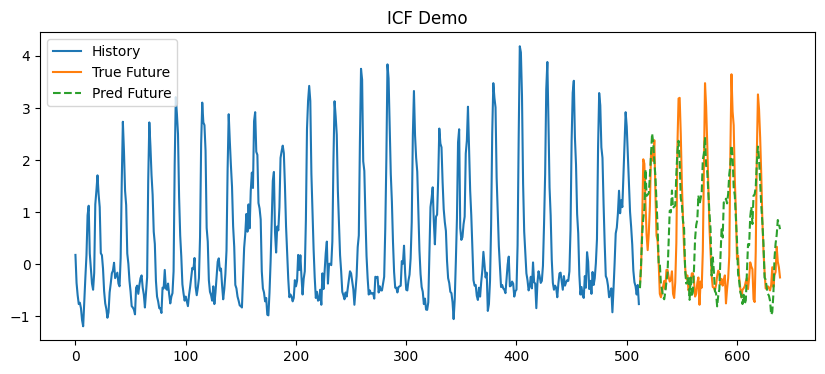

In [ ]:

@torch.no_grad()
def predict_with_context(pool, n_examples=cfg.max_examples_per_context, in_series_examples=cfg.in_series_examples):
    examples, y_future = sample_context(pool, cfg.history_len, cfg.horizon_len, n_examples, in_series_examples)
    arr = torch.from_numpy(np.stack(examples, axis=0)).unsqueeze(0).to(DEVICE)  # (1,N,L+H)
    yhat = model(arr).squeeze(0).detach().cpu().numpy()
    return examples[-1], y_future, yhat

hist_future, y_true, y_pred = predict_with_context(series_list)
print('Horizon MASE (single):', mase(y_true, y_pred))

plt.figure(figsize=(10,4))
L = cfg.history_len
plt.plot(range(L), hist_future[:L], label='History')
plt.plot(range(L, L+len(y_true)), y_true, label='True Future')
plt.plot(range(L, L+len(y_pred)), y_pred, label='Pred Future', linestyle='--')
plt.legend(); plt.title('ICF Demo'); plt.show()


## 11) Save — 学習済みチェックポイントの保存

In [ ]:

os.makedirs('checkpoints', exist_ok=True)
torch.save(model.state_dict(), 'checkpoints/icf_timesfm_demo.pt')
print('Saved: checkpoints/icf_timesfm_demo.pt')


Saved: checkpoints/icf_timesfm_demo.pt
